### Outline:

0. DataFrames: The Idea of Features and Observations.
1. Numerical Features: Bag of Words and The Idea of Matrices.
2. Recalling the Picture of Classification.
3. The Logic of Naive Bayes.
4. Balancing the Training Data.
5. Prediction and Model Evaluation.
6. Extras!

##### Summary:

In this notebook we will attempt to classify a collection of complaints against banking services by issue. The client is the Consumer Financial Protection Bureau. These complaints are sent in by email. If we can successfully distinguish between the type of complaint using only it's text, we can automatically label future complaints as they arrive in the Bureau's inbox. This will save time for the consumer. Alternatively, it could be used as backup system to verify the correctness of the consumer's label. This would make all subsequent statistics (such as sentiment analysis) that compare these categories, more accurate.

The data utilized in the problem comes from a public dataset of consumer complaints continuously released by the [Consumer Financial Protection Bureau](https://www.consumerfinance.gov/data-research/consumer-complaints/)

##### A note and a thank you: 

This notebook borrows from images, text, and code used in Harvard's CS109 course, in particular lab 10 from 2015. That being said, much of my own work is added and explanations are greatly simplified for a beginning audience. The analysis is carried out on a data set of consumer complaints regarding banking services from the Consumer Financial Protection Bureau.

If you enjoy getting your feet wet in this walkthrough, you should absolutely look into the open source lectures and labs on the [CS109 website](http://cs109.github.io/2015/) or the [official online course](https://www.extension.harvard.edu/academics/courses/introduction-data-science/15178) through Harvard Extension.



In [2]:
# Here we import many useful libraries.

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

def dateLookup(s):
    """
    Memoization solution for faster date_time parsing
    source: https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [3]:
# Here we import our pre-cleaned data.

dataTypes = {
    'product':'category',
    'sub_product':'category',
    'issue':'category',
    'sub_issue':'category',
    'text':str,
    'clean_text':str,
    'pub_reply':str,
    'company':'category',
    'state':'category',
    'zip_code':str,
    'tags':str,
    'cust_reply':'category',
    'timely_reply':'int64',
    'disputed':'int64',
    'ID':'int64'
}

data = pd.read_csv('Cleaned_Consumer_Complaints.csv',index_col="Index",dtype=dataTypes)

#Convert datetimes    
for col in ['date_received', 'date_sent']:
    data[col] = dateLookup(data[col])
    
full_issue_names = {
    'Account':'Account opening, closing, or management',
    'Transactions':'Deposits and withdrawals',
    'Payments':'Making/receiving payments, sending money',
    'Low Funds':'Problems caused by my funds being low',
    'Card':'Using a debit or ATM card'
}

issues = sorted(list(data['issue'].unique()))

### Features and Observations

The idea of features and observations is central to statistics and machine learning. We can think of each observation as an entity (500 different pieces of fruit) and each feature as a quality of that entity. Each piece of fruit might have a roundness, weight, and color. The "label" we want to classify our fruit by, such as {apples,oranges} also counts as a feature.

In [4]:
# What the full data set looks like in a pandas DataFrame.
# Each row is an observation (a complaint)
# Each column is a feature (a quality of that complaint)

data.head(5)

,date_received,product,sub_product,issue,sub_issue,text,pub_reply,company,state,zip_code,tags,date_sent,cust_reply,timely_reply,disputed,ID,clean_text
Index,,,,,,,,,,,,,,,,,
0,2017-04-12,Bank account or service,Checking account,Low Funds,NaN,I have documentation that shows that US Bank w...,Company has responded to the consumer and the ...,U.S. BANCORP,CA,928XX,NaN,2017-04-12,Closed with explanation,1,0,2431565,I have documentation that shows that US Bank w...
1,2017-01-18,Bank account or service,Other bank product/service,Account,NaN,After 2 years of service with no issues Coinba...,Company believes it acted appropriately as aut...,"Coinbase, Inc.",TX,770XX,NaN,2017-01-19,Closed with explanation,1,1,2291872,After 2 years of service with no issues Coinba...
2,2016-06-01,Bank account or service,Other bank product/service,Payments,NaN,This complaint is regarding Wells Fargo. XX/XX...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,NV,891XX,NaN,2016-06-01,Closed with monetary relief,1,0,1949163,This complaint is regarding Wells Fargo. I re...
3,2016-07-05,Bank account or service,Checking account,Low Funds,NaN,I bank with Bank of America using the paybill ...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",NC,283XX,NaN,2016-07-05,Closed with monetary relief,1,0,1997875,I bank with Bank of America using the paybill ...
4,2015-11-21,Bank account or service,Checking account,Low Funds,NaN,This is my fifth complaint against Key Bank be...,NaN,KEYCORP,NY,138XX,NaN,2015-11-21,Closed with explanation,1,1,1666956,This is my fifth complaint against Key Bank be...


In [5]:
# These are the features we care about.
data[['clean_text','issue']].head(5)

,clean_text,issue
Index,,
0,I have documentation that shows that US Bank w...,Low Funds
1,After 2 years of service with no issues Coinba...,Account
2,This complaint is regarding Wells Fargo. I re...,Payments
3,I bank with Bank of America using the paybill ...,Low Funds
4,This is my fifth complaint against Key Bank be...,Low Funds


In [6]:
# Here's a global summary of our DataFrame.
# There are about 15000 entries. Our features of interest don't have null values.

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14888 entries, 0 to 14887
Data columns (total 17 columns):
date_received    14888 non-null datetime64[ns]
product          14888 non-null category
sub_product      14888 non-null category
issue            14888 non-null category
sub_issue        0 non-null category
text             14888 non-null object
pub_reply        8629 non-null object
company          14888 non-null category
state            14769 non-null category
zip_code         14688 non-null object
tags             2430 non-null object
date_sent        14888 non-null datetime64[ns]
cust_reply       14888 non-null category
timely_reply     14888 non-null int64
disputed         14888 non-null int64
ID               14888 non-null int64
clean_text       14888 non-null object
dtypes: category(7), datetime64[ns](2), int64(3), object(5)
memory usage: 1.4+ MB


Using matplotlib, we can make a plot to show the "Class balance" between the labels. This balance of labels is important to our classification task as it will directly reflect what is under or over represented in the training and testing data.

Too few examples of a class may make that class very hard to predict for.

This is often compensated for by under or oversampling classes.

Luckily, we have enough examples of each class to create a balanced (equal frequency per class) training set and still have a sizeable test set.


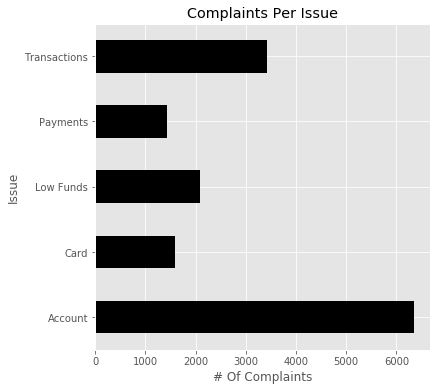

In [7]:
grp = data.groupby(['product','issue'])['text'].count()
grp['Bank account or service'].plot(kind='barh',title = 'Complaints Per Issue',color='black',figsize=(6,6))
plt.xlabel('# Of Complaints')
plt.ylabel('Issue')
plt.show()

### Matrices and Bag of Words

Machine learning usually works on numerical matrices and vectors.

A matrix is like a DataFrame, but with only numbers as entries and labels.

A vector is a single row or column of a matrix. This is like a list of floats in python.

Numpy is a python library that does very efficient calculations with matrices and vectors.

In [8]:
# This is a very important matrix called the Identity Matrix.
# For multiplication between numbers, we rely on 1 to give us back what we put in.
# That's called the multiplicative identity.
# In matrix multiplication, the identity matrix has the same job.
# This matrix is 5x5.

np.eye(5)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [9]:
np.array([1,0,0,0,0])

array([1, 0, 0, 0, 0])

We want a vector that describes a document, which we can turn into a series of vectors describing all the documents (a matrix). What do we do?

There are multiple solutions here and this is a non-trivial problem by itself. Let's choose something simple, effective and proven. Let's simply count how many times each word appears in each document.

Each word will be a "feature", and will have a count for every document. But what words will we choose to count up? That's an important problem too. We'll call the words we choose to count the "vocabulary."

One vocabulary we can create is the collection of all words used in the text.

Let's take the following toy example, borrowed from Harvard CS109's Lab 10 from 2015:

In [10]:
documents = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(documents)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(documents)

# call `transform` to convert text to a bag of words
sparse_matrix = vectorizer.transform(documents)

# CountVectorizer uses a sparse array to save memory, but it's easier 
# to work with a "normal" numpy matrix
matrix = sparse_matrix.todense()

print("")
print("Transformed text vector is \n{}".format(matrix))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


Cool! But what will this look like on our data? A lot bigger, right?

Let's calculate it (this takes about 45 seconds in my local environment) and then print it out for fun.

This time we'll allow ourselves to include terms of 2-6 words as well as 1 word terms, to add to our predictive power at modeling time.

We can imagine that 2 and 3 word phrases may be more specific, and therefore more predictive, of a class. However, we can also imagine that they will tend to be rarer than their consituent 1 word phrases.

To put a constraint on what features are common enough to be useful, we'll say that the term must occur in at least one percent of the documents. In a more rigorous exercise, we might consider this parameter to be part of the "search" for an optimal set of parameters to use in the overall task.


In [11]:
documents = data['clean_text']
vectorizer = CountVectorizer(stop_words='english',min_df=0.01,max_df=1.0,ngram_range=(1,6), max_features = 15000)
X = vectorizer.fit_transform(documents)

In [12]:
print(X.todense())
print("")
print("Words for each feature:")
# One statement to print them all...
print(vectorizer.get_feature_names())

[[0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [2 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [3 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]

Words for each feature:
['00', '00 account', '00 balance', '00 bank', '00 bonus', '00 called', '00 cash', '00 charge', '00 check', '00 checking', '00 checking account', '00 debit', '00 deposit', '00 did', '00 dollars', '00 fee', '00 fees', '00 money', '00 month', '00 overdraft', '00 overdraft fee', '00 overdraft fees', '10', '10 00', '10 business', '10 business days', '10 days', '100', '100 00', '1000', '1000 00', '10000', '10000 00', '12', '12 00', '120', '14', '15', '150', '150 00', '1500', '1500 00', '16', '20', '20 00', '200', '200 00', '2000', '2000 00', '2014', '2015', '2016', '2016 received', '2017', '24', '24 hours', '25', '25 00', '250', '250 00', '30', '30 00', '30 days', '300', '300 00', '35', '35 00', '36', '36 00', '360', '40', '400', '400 00', '45', '48', '50', '50 00', '500', '500 00', '5000', '5000 00', '60', '60 days', '90', '90 days', 'aadva

Okay, that's too many terms to count on our toes and fingers, but getting immersed in the terms we're dealing with was hopefully a nice qualitative exercise.

Let's see a count.

In [15]:
X.shape

(14888, 1492)

1492 words.14888 documents. Great. Numbers are super useful.

Let's get labels to go with those features.

In [16]:
y = data['issue']

# The Picture of Classification

![Decision Boundaries](decision_boundaries.jpg)
Borrowed from Hanspeter Pfister's Lecture 9 slides in Harvard CS109, 2015.

Our classifier's job is to draw a boundary that seperates the members of each class in the "Feature Space."

Our Feature Space has as many dimensions as we have terms, so we can't visualize this one in the same way. The logic still applies, though!

In this case the boundary was a line, but depending on how the data is seperated, we might want to draw a much different shape. If our shape is too contrived (more to do with the training data than the overall population), we'll have high error from variance. 

If our shape is unrelated to or too simple to characterize the relationships in the data, it will have higher error from bias.

Of course, there's also just some error we can never get past, even with an "ideal model." This is the irreducible error.

If we just draw the a decision boundary and use it to classify the data, this is called a "discriminative classifier."

Our classifier we will first attempt to model the probability of a class given the data. IE This is 79% likely to be an 'Account' complaint. This is called a "Generative Classifier" because it builds a full probability model for each outcome. The decision boundary is arrived at by choosing which outcome is "most likely." 

The field of statistics that likes to treat everything as a probability distribution is called Bayesian Statistics. This is actually a suprisingly helpful thing to do.


# The Logic of Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$ 

To consider the whole vector of features, we multiply a chain of the probabilities on the right hand side.

$$P(f \vert c)  = \prod_i P(f_i | c) $$

To avoid a numerical error called underflow when multiplying these really small decimals, we turn the multiplication into addition in log space. This is a neat trick you might have done in calculus class.

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

Let's include the discrete count values that go into computing these probabilities. Now, in order to avoid multiplying our result by zero or trying to take the log of zero, we add a integer value called alpha to every value. Usually alpha equals 1, in which case it is called "Laplace smoothing."

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

##### Multinomial Naive Bayes 

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. In the case, calculating the probability corresponds with the multinomial distribution- a probability distribution for rolling a $k$ sided die $n$ times where $k$ is the number of classes and $n$ is the number of observations.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

A useful effect of multinomial bayes is that our decision boundary will linear, just like the one that we've been visualizing.

### Splitting between a Balanced training set and Stratified test set

We will translate the concept of "Seen data" here to the more conventional "Training Set."

This is the data the model gets to see and adjust itself to. "Unseen data" will relate more to the "Test Set." This is the data that we then test our model's performance on to see if it "generalizes" to successfully predict new examples.

A balanced set is one that evenly represents each class. A stratified set is one that represents the classes with the same relative frequency they had in the original data set.

Normally we could use Sklearn's built in train_test_split method, but using a balanced set requires some hand-coding (as far as I know.)

In [22]:
#Take a balanced sampling for an alternative training set and an unbalanced/stratified test set
np.random.seed(42)

class_balance = np.array([len(data[data['issue'] == issue]) for issue in issues])

data_copy = data.copy()
training_set = np.array([])
test_set = np.array([])
smallest_class_total = np.min(class_balance)
test_frac = 0.33
training_size = int(np.floor(smallest_class_total*(1-test_frac)))
min_test_size = smallest_class_total-training_size
test_sizes = np.floor(class_balance*(min_test_size/smallest_class_total)).astype(int)

for counter, class_size in enumerate(class_balance):
    training_selections = np.random.choice(
        data_copy[data_copy['issue'] == issues[counter]].index,
        size=training_size,
        replace=False
    )
    training_set = np.append(training_set,training_selections)
    data_copy = data_copy.drop(training_selections)
    
    test_selections = np.random.choice(
        data_copy[data_copy['issue'] == issues[counter]].index,
        size=test_sizes[counter],
        replace=False
    )
    test_set = np.append(test_set,test_selections)
    data_copy = data_copy.drop(test_selections)

training_set = training_set.astype(int)
test_set = training_set.astype(int)

### Let's train the model and make some predictions!

Notice how little code is required below. 

Scikit-Learn provides a very nicely abstracted interface to Machine Learning algorithms.
A similiar classifier, like a Support Vector Machine or K-Nearest Neighbor, will usually provide a similiar interface.

In [23]:
X_train, y_train = X[training_set],y[training_set]
X_test, y_test = X[test_set], y[test_set]

In [24]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X=X_train,y=y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The confusion matrix below gives us an image of which classes are mistaken for each other. We can relate this back to the idea of seperability intuitively.

Each row of this matrix tells us what portion of the documents predicted to be a given class (predicted class) were actually labeled as each class (actual class). As we can see, Account predictions are sometimes made for payments and transactions classes. Similarly, Payments predictions are sometimes made for card and transactions.

We can think of this as an issue of "seperability" in the space, where our model tends to favor one class over another when it comes to deciding the ambiguous cases.

##### Grasping the relationship between this matrix and the picture of classification is goal of this presentation.

We'll address standard metrics for assessing model performance below.

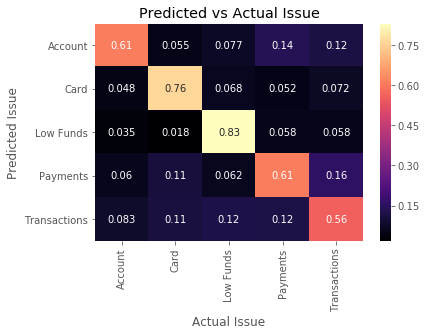

              precision    recall  f1-score   support

     Account       0.73      0.61      0.66       960
        Card       0.72      0.76      0.74       960
   Low Funds       0.72      0.83      0.77       960
    Payments       0.62      0.61      0.62       960
Transactions       0.58      0.56      0.57       960

 avg / total       0.67      0.67      0.67      4800

Num of training examples : [ 960.  960.  960.  960.  960.]
Num of testing examples : [2095  527  688  472 1130]


In [25]:
predictions = mnb_classifier.predict(X=X_test)
confusion = np.matrix(metrics.confusion_matrix(y_test,predictions))
rel_confusion = confusion/confusion.sum(axis=1)
rc_df = pd.DataFrame(rel_confusion,index=issues,columns=issues)
heat = sns.heatmap(rc_df,cmap='magma',annot=True)
heat.set(xlabel = 'Actual Issue',ylabel = 'Predicted Issue',title= 'Predicted vs Actual Issue')
plt.show()
print(metrics.classification_report(y_test,predictions))
print('Num of training examples :',mnb_classifier.class_count_)
print('Num of testing examples :',test_sizes)

Precision tells us what fraction of all of our positive predictions were true. 

Recall tells us what fraction of all of the available positives we captured in our predictions.

We can imagine different scenarios when we might have a preferences for either. 

The dilemma goes like this: Is it more important to only predict positively when we're certain of it, or is it more important to make a positive prediction if think there's any legitimate chance it's a true positive?

Let $tp$  mean true positives, $fp$ false positives, and $fn$ false negatives.

Precision is equal to $$ \frac{tp}{tp+fp}$$

Recall is equal to $$ \frac{tp}{tp+fn}$$

The F1 score combines these by taking their harmonic mean. 

F1 is equal to $$ 2 \cdot \frac{precision \cdot recall}{precision+recall} $$

Support, as you might have guessed, is just the number of training examples.

So, we see there are certain categories that are easily mistaken for one another.

We have a number of ways to try to remedy this situation, none of which are guaranteed to to help us. We can save this dilemma for another day!


## EXTRAS:

### Finding the most predictive terms for each class

Remember that naive bayes is a generative classifier and can tell us the probability of a class given a term vector?

This works to our advantage in that we can predict the probability of a class given 1 occurence of each term in the vocabulary.

This allows us to see which terms of maximally and minimally predictive of each class - a nice qualitative insight.

In [26]:
vocabulary = np.array(vectorizer.get_feature_names())

x = np.eye(X_test.shape[1])
probs = mnb_classifier.predict_log_proba(x)

for counter, issue in enumerate(issues):
    
    print('--------------------------------------')
    print("{:>20}".format(issue))
    print('--------------------------------------')
    
    ind = np.argsort(probs[:,counter])
    
    likely_terms = vocabulary[ind[:10]]
    unlikely_terms = vocabulary[ind[-10:]]

    likely_prob = probs[ind[:10],counter]
    unlikely_prob = probs[ind[-10:],counter]
    
    print("Likely terms\t     P(class | term)")
    for w, p in zip(likely_terms, likely_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
    print("Unlikely terms\t     P(class | term)")
    for w, p in zip(unlikely_terms, unlikely_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
        
plt.show()

--------------------------------------
             Account
--------------------------------------
Likely terms	     P(class | term)
         provisional 0.99
              debits 0.98
    charge overdraft 0.98
      withdraw money 0.97
              mobile 0.96
        stop payment 0.96
             weekend 0.96
  insufficient funds 0.96
     funds available 0.96
                 nsf 0.96
Unlikely terms	     P(class | term)
   promotional offer 0.12
      promotion code 0.11
completed requirements 0.11
citigold checking account 0.09
   citigold checking 0.09
    met requirements 0.08
           promotion 0.07
          aadvantage 0.07
               bonus 0.07
            citigold 0.05
--------------------------------------
                Card
--------------------------------------
Likely terms	     P(class | term)
           promotion 1.00
               bonus 0.99
            citigold 0.99
            00 bonus 0.99
                 ira 0.99
    met requirements 0.99
   citigold che

We can see the distribution of P(Class|Term) values as a probability density function approximated by a histogram, or as an empirical cumulative distribution. Notice that the peak of this distribution is at 0.8. If we allowed more and more common words into the vocabulary, we could expect to see many more terms with lower P values than these.

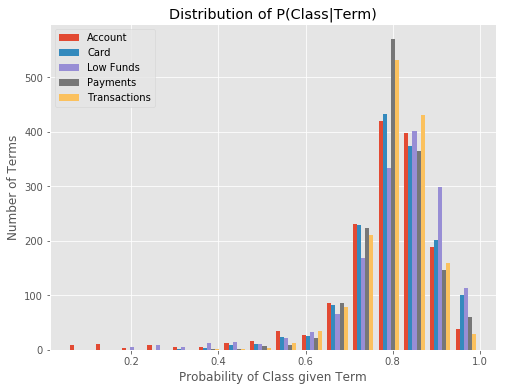

In [27]:
p = (1 - np.exp(probs))
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(p, bins = 16)
plt.title('Distribution of P(Class|Term)')
plt.xlabel('Probability of Class given Term')
plt.ylabel('Number of Terms')
plt.legend(issues)
plt.show()

In [28]:
np.median(p,axis=0)

array([ 0.8060505 ,  0.81198122,  0.8302432 ,  0.80235754,  0.80890306])

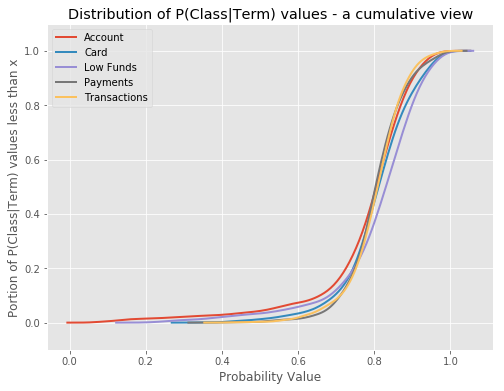

In [29]:
prob_df = pd.DataFrame(p,columns=issues)
fig, ax = plt.subplots(figsize=(8,6))
for issue in issues:
    sns.kdeplot(prob_df[issue],linewidth=2,cumulative=True)

plt.title('Distribution of P(Class|Term) values - a cumulative view')
plt.xlabel('Probability Value')
plt.ylabel('Portion of P(Class|Term) values less than x')
plt.ylim([-0.1,1.1])
plt.show()

### Add something here! Play around with stuff.